## 測試Clean Chinese HandWrite data 使用不同Classifier的預測結果

In [55]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from  sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from  sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
random_state = 0

# 測試50個字

In [56]:
img_list = []
data_path = './clean_data/'
num_class = 50
#label dir 
folder_list = os.listdir(data_path)
folder_list.sort(key=lambda x: int(x))
for i in folder_list[:num_class]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            

## Load Image

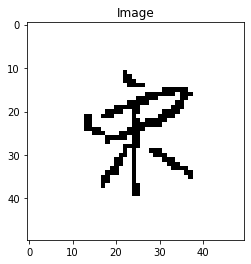

In [57]:
plt.title('Image')
plt.imshow(Image.open(img_list[0][0]),cmap='gray')

In [58]:
total_img = []
total_label = []
for file,label in img_list:
    img  = Image.open(file).convert('L').resize((50,50),Image.BILINEAR)
    total_label.append(label)
    total_img.append(np.array(img).reshape(-1))
total_img = np.array(total_img)
total_label = np.array(total_label)
print("Total label shape:",total_label.shape)
print("Total image shape:",total_img.shape)

Total label shape: (2641,)
Total image shape: (2641, 2500)


# Split train and test set

In [59]:
X_train,X_test,Y_train,Y_test = train_test_split(total_img,total_label,test_size=0.2,random_state=0)
X_train_scale = preprocessing.scale(X_train)
X_test_scale = preprocessing.scale(X_test)

# PCA explain ratio

Text(0, 0.5, 'cumulative explained variance')

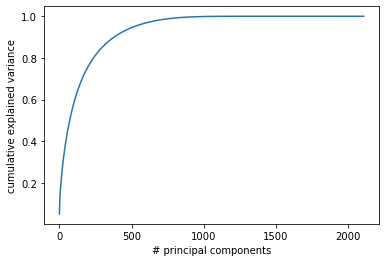

In [60]:
# 多少components 就可以代表0.95的資料
n_compons_rate = 0.95
pca = PCA()
pca.fit(X_train)
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

dim reduction one image

principle components shape: (2112, 2500)


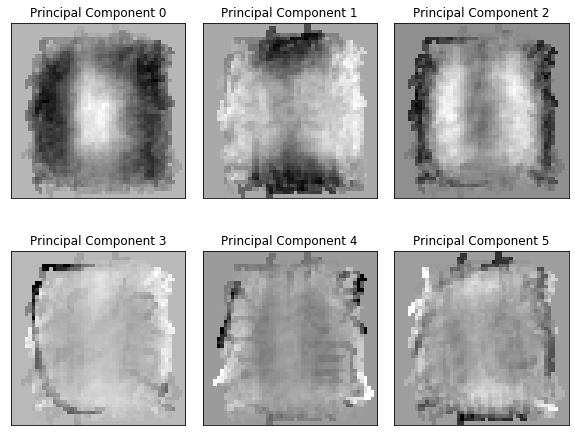

In [61]:
from sklearn.preprocessing import minmax_scale
pca = PCA(random_state=0)
trans_img = pca.fit_transform(X_train_scale)

scaled_comps = minmax_scale(pca.components_,axis=1)
print("principle components shape:",pca.components_.shape)
fig,axes = plt.subplots(2,3,figsize=(10,8),
                        subplot_kw = {"xticks":[],'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    c = scaled_comps[i]
    ax.set_title('Principal Component '+str(i))
    ax.imshow(c.reshape(50,50),cmap='gray')


# predict function

In [7]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

## Confusion matrix 

In [9]:
def plot_confusion_matrix(confuse_matrix,title="Confusion Matrix",cmap=plt.cm.Blues):
    plt.imshow(confuse_matrix,interpolation='nearst',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks,names,rotation=90)
    plt.yticks(tick_marks,names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## PCA components數 影響 SVM accuracy

In [29]:
def differ_components_SVM(X_train,Y_train,X_test,Y_test,):
    best_acc = 0
    best_rate = 100
    for i in range(90,0,-10):
        pca = PCA(i/100,random_state=random_state)
        pca.fit(X_train)
        transformed_images = pca.transform(X_train)
    #     print("transformed_images.shape:",transformed_images.shape)
        transform_test = pca.transform(X_test)
        clf = svm.SVC()
        clf.fit(transformed_images,Y_train)
        res = clf.predict(transform_test)
        acc = predict_accuracy(res,Y_test)
        if best_acc<acc:
            best_acc = acc
            best_rate = i/100
        
        print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))
    print("Best accuracy:{:.2%} , Best component rate:{}".format(best_acc,best_rate))


In [11]:
differ_components_SVM(X_train_scale,Y_train,X_test_scale,Y_test)

379 components accuracy:64.27%
233 components accuracy:65.60%
153 components accuracy:67.86%
100 components accuracy:63.33%
63 components accuracy:55.95%
38 components accuracy:45.94%
21 components accuracy:32.70%
10 components accuracy:14.56%
3 components accuracy:11.53%
Best accuracy:67.86% , Best component rate:0.7


## PCA

In [54]:
pca = PCA(0.8,random_state=random_state)
# pca.fit(X_train_scale)
pipe = make_pipeline(StandardScaler(),pca)
pipe.fit(X_train)
transformed_train = pipe.transform(X_train)
transformed_test = pipe.transform(X_test)

print('-----PCA dimension reduction----')
print("transformed train images.shape:",transformed_train.shape)
print("transformed test  images.shape:",transformed_test.shape)


-----PCA dimension reduction----
transformed train images.shape: (2112, 233)
transformed test  images.shape: (529, 233)


## PCA reconstruct Image with different   component

In [13]:
def diff_component_reconstruct(X_train_scale,X_test_scale,X_train,k):
    diff_reconstruct=[]
    diff_reconstruct.append((Image.fromarray(X_train[k].reshape(50,50) ,'L'),"Ori_img"))

    for i in range(95,0,-10):
        pca = PCA(i/100,random_state=0)
        pca.fit(X_train_scale)
        transformed_train = pca.transform(X_train_scale)
        reconstruct_image = pca.inverse_transform(transformed_train)
        reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
        img_pca = Image.fromarray(reconstruct_image[k],'L')
        print("components_number:",pca.components_.shape[0])
        diff_reconstruct.append((img_pca,pca.components_.shape[0]))
    fig, axes = plt.subplots(1,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        img_pca = diff_reconstruct[i][0]
        ax.set_title(diff_reconstruct[i][1])
        ax.imshow(img_pca,cmap='gray')
       
   
diff_component_reconstruct(X_train_scale,X_test_scale,X_train,k=10)

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(3,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

reconstruct_image = pca.inverse_transform(transformed_train)
reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
for i, ax in enumerate(axes.flat):
        img_pca = Image.fromarray(reconstruct_image[i] ,'L')
        ax.imshow(img_pca,cmap='gray')

# LDA

In [21]:
def LDA(X_train,Y_train,X_test,Y_test):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train,Y_train)
    transform_images = lda.transform(X_train)
    transform_test = lda.transform(X_test)
    return transform_images,transform_test
lda_train,lda_test = LDA(X_train_scale,Y_train,X_test_scale,Y_test)

## KPCA

In [35]:
from sklearn.decomposition import KernelPCA
def KPCA(X_train,Y_train,X_test,Y_test):
    kpca = KernelPCA(n_components=232,kernel='linear')
    kpca.fit(X_train)
    transform_images = kpca.transform(X_train)
    transform_test = kpca.transform(X_test)
    return transform_images,transform_test
kpca_train,kpca_test = KPCA(X_train_scale,Y_train,X_test_scale,Y_test)

# SVM 

In [36]:
def SVM(X_train,Y_train,X_test,Y_test):
    clf = svm.SVC(kernel='linear',random_state=random_state)
    clf.fit(X_train,Y_train)
    res = clf.predict(X_test)
    return predict_accuracy(res,Y_test)

print("PCA+SVM:{:.2%}".format(SVM(transformed_train,Y_train,transformed_test,Y_test))) 
print("KPCA+SVM:{:.2%}".format(SVM(kpca_train,Y_train,kpca_test,Y_test))) 
print("LDA+SVM:{:.2%}".format(SVM(lda_train,Y_train,lda_test,Y_test)))


PCA+SVM:73.53%
KPCA+SVM:72.59%
LDA+SVM:14.18%


## KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

def KNN(X_train,Y_train,X_test,Y_test):
    knn =  KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,Y_train)
    res = knn.predict(X_test)
#     knn_cm = metrics.confusion_matrix(Y_test,res)
    
   
    return predict_accuracy(res,Y_test)

print("PCA+KNN:{:.2%}".format(KNN(transformed_train,Y_train,transformed_test,Y_test))) 
print("KPCA+KNN:{:.2%}".format(KNN(kpca_train,Y_train,kpca_test,Y_test))) 
print("LDA+KNN:{:.2%}".format(KNN(lda_train,Y_train,lda_test,Y_test)))

PCA+KNN:71.46%
KPCA+KNN:72.21%
LDA+KNN:14.74%


# Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
def perceptron(X_train,Y_train,X_test,Y_test):
    clf =Perceptron(tol=1e-5,random_state=random_state)
    clf.fit(X_train,Y_train)
    clf.score(X_train,Y_train)
    clf.score(X_test,Y_test)
    res = clf.score(X_test,Y_test)
    return res
print("PCA+Perceptron:{:.2%}".format(perceptron(transformed_train,Y_train,transformed_test,Y_test))) 
print("KPCA+Perceptron:{:.2%}".format(perceptron(kpca_train,Y_train,kpca_test,Y_test))) 
print("LDA+Perceptron:{:.2%}".format(perceptron(lda_train,Y_train,lda_test,Y_test)))

# MLP

In [93]:
mlp_res = [] 

def MLP(X_train,Y_train,X_test,Y_test,hidden_layer,max_iter ):
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer,solver='adam',activation='relu',max_iter=max_iter,random_state=random_state)
    clf.fit(X_train,Y_train)
    res = clf.predict(X_test)
    return predict_accuracy(res,Y_test)
max_iter= 5000
hidden_size = (256)
#  print("PCA+MLP:{:.2%}".format(MLP(transformed_train,Y_train,transformed_test,Y_test,hidden_size,max_iter))) 
#     print("KPCA+MLP:{:.2%}".format(MLP(kpca_train,Y_train,kpca_test,Y_test,hidden_size,max_iter))) 
#     print("LDA+MLP:{:.2%}".format(MLP(lda_train,Y_train,lda_test,Y_test,hidden_size,max_iter)))
for i in range (128,2500,128):
    print(i)
    hidden_size = (i)
    mlp_res.append(MLP(transformed_train,Y_train,transformed_test,Y_test,hidden_size,max_iter))
   


128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432


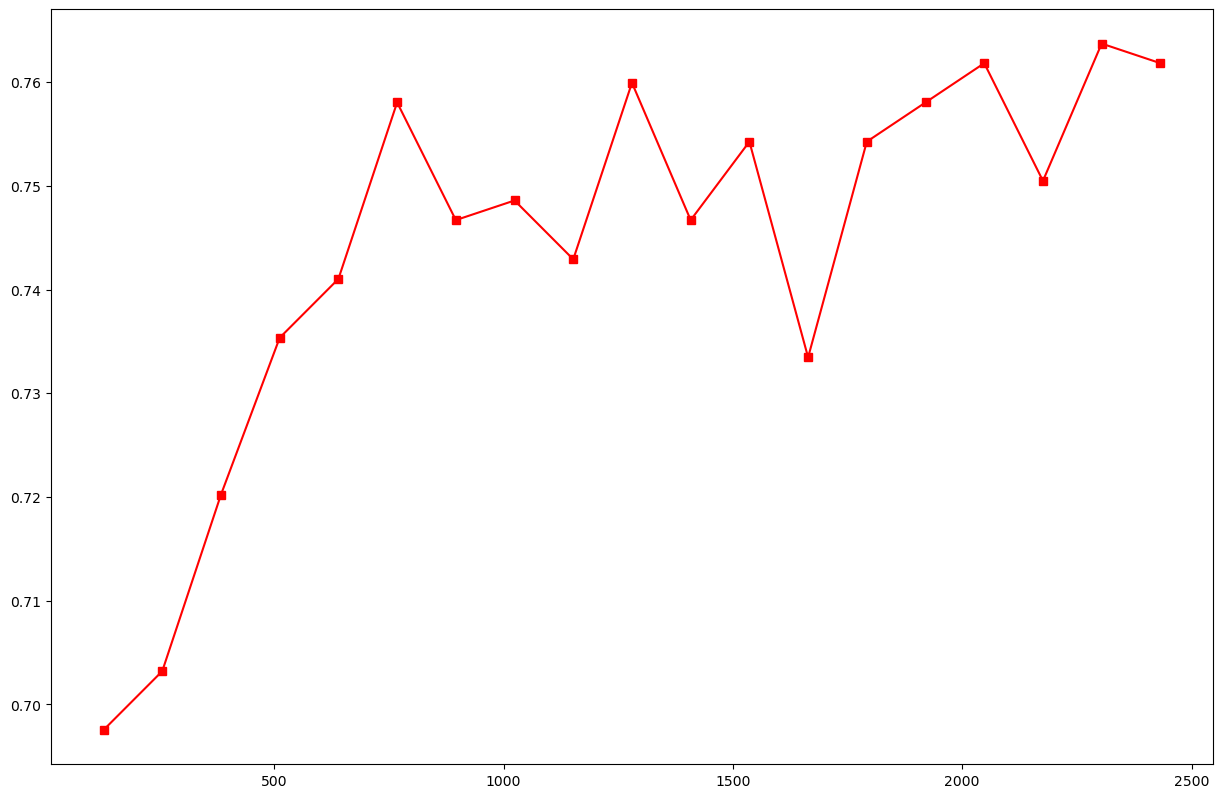

In [92]:
x_ = [i for i in range(128,2500,128)]
mlp_res
plt.figure(figsize=(15,10),dpi=100,linewidth = 2)
plt.plot(x_,mlp_res,'s-',color = 'r')

## Naive Bayes

In [39]:
from sklearn.naive_bayes import *
Categorical_NB = CategoricalNB()
Categorical_NB.fit(X_train, Y_train)
res = Categorical_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.07561436672967864

In [45]:
Complement_NB = ComplementNB()
Complement_NB.fit(X_train, Y_train)
res = Complement_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.4763705103969754

In [53]:
Gaussian_NB = GaussianNB()
Gaussian_NB.fit(X_train, Y_train)
res = Gaussian_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.2438563327032136

In [52]:
Multinomial_NB = MultinomialNB()
Multinomial_NB.fit(X_train, Y_train)
res = Multinomial_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.5822306238185255